In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qutip import *

In [15]:
Nr = 10
a = destroy(Nr)

sz = (a.dag()*a).full()
sx = a.full()
psi0 = coherent(Nr, 0.2).full().reshape(10,)
H = 6*sz
Ls = [np.sqrt(2)*sx, 0.05*sz]

Heff = H - 1j/2 * sum([L.T.conjugate()@L for L in Ls]) # effective Hamiltonian

In [20]:
psi0@sz@psi0

(0.04000000000000003+0j)

In [27]:
psi1=sx@psi0
psi1@sz@psi1

(0.0016000000000000018+0j)

In [16]:
b00 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
dt = 0.2/np.linalg.norm(H, ord ='fro') # timestep
m = 1000 # number of steps
tf = dt*m # final time
times = np.linspace(0,tf,m)
dt

0.0019744962591969747

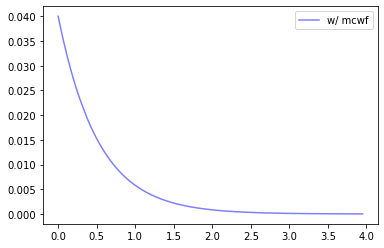

In [55]:
sample = 150 # number of samples

mean = np.zeros(m, dtype = complex) #array for the results
n = 0
for count in range(sample):
    t = 0
    waves = [psi0]
    for t in times[1:]:
        # generate a random number in (0,1]
        u = np.random.random()
        # array of jump probabilities
        dps = [dt * (waves[-1].T.conjugate() @ (L.T.conjugate()@L)@waves[-1]) for L in Ls]
        # renormalisation factor 1-dP
        dP = np.sum(dps)
        # test
        if dP <= u:
            #temp = (np.eye(len(psi0))-1j*Heff.T.conjugate()*dt)@(waves[-1])
            temp = (np.eye(len(psi0))-1j*Heff*dt)@(waves[-1])
        else:
            n+=1
            # new random number
            u = np.random.random()
            Q = np.cumsum(dps)/dP
            # pick the jump that has occurred
            k = np.searchsorted(Q, u, side = 'left')
            temp = Ls[k]@waves[-1]
        waves.append(temp/np.linalg.norm(temp))
    mean += np.array([wave.T.conjugate()@sz@wave for wave in waves])

mean = np.array(mean)/sample

fig, ax = plt.subplots()
ax.plot(times, np.real(mean), 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();

In [50]:
n/sample

9.026666666666667

In [56]:
def RK4_evo(dt, Heff, size):
    '''RK4'''
    k1 = -1j*Heff
    k2 = -1j*Heff*(1+k1/2*dt)
    k3 = -1j*Heff*(1+k2/2*dt)
    k4 = -1j*Heff*(1+k3*dt)
    return np.eye(size)+dt/6*(k1+2*k2+2*k3+k4)

def my_mcsolve(psi0, H, times, c_ops=[], e_ops=[], args={}, ntraj=150):
    '''Calculate the stochastic dyanmics by MCWF method, using the inaccurate Euler method'''
    
    mean = np.zeros(m, dtype = complex) #array for the results
    
    for count in tqdm(range(ntraj)):
        t = 0
        waves = [psi0]
        for t in times[1:]:
            # generate a random number in (0,1]
            u = np.random.random()
            # array of jump probabilities
            dps = [np.real(dt * (waves[-1].T.conjugate()@(L.T.conjugate()@L)@waves[-1])) for L in Ls]
            # renormalisation factor 1-dP
            dP = np.sum(dps)

            # test
            if dP <= u:
                temp = RK4_evo(dt, H, len(psi0))@(waves[-1])
                #temp = (np.eye(len(psi0))-1j*H*dt)@(waves[-1])
                #temp = sp.linalg.expm(-1j*H*dt)@(waves[-1])
            else:
                # new random number
                u = np.random.random()
                Q = np.cumsum(dps)/dP
                # pick the jump that has occurred
                k = np.searchsorted(Q, u, side = 'left')
                temp = Ls[k]@waves[-1]
            waves.append(temp/np.linalg.norm(temp))
        mean += np.array([(wave.T.conjugate()@sz@wave) for wave in waves])

    mean = np.array(mean)/ntraj
    return mean

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:43<00:00,  3.46it/s]


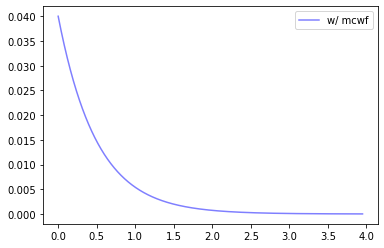

In [57]:
mean = my_mcsolve(psi0, Heff, times)
fig, ax = plt.subplots()
ax.plot(times, np.real(mean), 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();

## QuTip Benchmaraking

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.02s. Est. time left: 00:00:00:00
40.0%. Run time:   0.03s. Est. time left: 00:00:00:00
50.0%. Run time:   0.03s. Est. time left: 00:00:00:00
60.0%. Run time:   0.04s. Est. time left: 00:00:00:00
70.0%. Run time:   0.05s. Est. time left: 00:00:00:00
80.0%. Run time:   0.05s. Est. time left: 00:00:00:00
90.0%. Run time:   0.06s. Est. time left: 00:00:00:00
Total run time:   0.07s


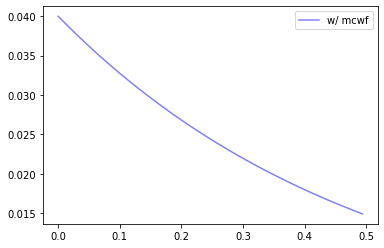

In [14]:
a = destroy(Nr)

sz = 6*(a.dag()*a)
psi0 = coherent(Nr, 0.2)
H0 = sz
c_ops = [np.sqrt(2)*a, 0.05*sz]
e_ops = [a.dag()*a]

meResult = mesolve(H0, psi0, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))
nc = meResult.expect[0]

fig, ax = plt.subplots()
ax.plot(times, nc, 'b-', alpha = 0.5, label = 'w/ mcwf');
ax.legend();